<a href="https://colab.research.google.com/github/IANovoselov/well/blob/main/well.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [246]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from dataclasses import dataclass
from typing import Optional

In [247]:
plt.rcParams.update({'font.size': 16})

In [248]:
 # Исходные данные для моделировния
p_0 = 0.1  # Атмосферное давление
p_L = 1.5  # Давление в линии нефтесбора

# Ограничения
h_lim = 100  # По уровню над приёмом насос
betta_G_lim = 0.25  # По газу у первой ступени

In [249]:
class PhysValue:
  """Класс изменяющейся физической виличины"""

  def __init__(self, start_value: float, avg_value: Optional[float] = None) -> None:
    self.start_value = start_value
    self.avg_value = avg_value or start_value

In [250]:
@dataclass
class Oil:
  """Нефть"""
  # Удельный вес
  gamma_oil = 0.0068  # нефти
  gamma_water = 0.011  # воды
  gamma_gas = 0.000008  # газа

  betta = 0.3  # Объёмная доля воды
  G = 100  # Газовый фактор

  gamma = None

  def __post_init__(self):
    # Удельный вес газожидкостной смеси
    self.gamma = (1-self.betta)*self.gamma_oil+self.betta*self.gamma_water


class Reservoir:
  """Пласт"""
  # Фонтанирующая скважина
  # p_R = 28  # Среднепластовое давление
  # p_G0 = 25  # Давление насыщенного газа

  w_1 = 12  # Гидропроводность из пласта в ПЗ скважины
  w_2 = 60  # Гидропроводность из ПЗ в забой
  T_2 = 0.4  # Постоянна времени притока


  def __init__(self):
  # Гидросопротивления
    self.r_1 = 1/self.w_1  # Пласт - ПЗ
    self.r_2 = 1/self.w_2  # ПЗ - забой
    self.r_R = self.r_1 + self.r_2
    self.p_R = 21.65  # Среднепластовое давление

class Pump:
  """Насос"""
  # Параметры насоса
  H_N = 2000  # уровень подвеса
  q_0 = 90  # номинальный дебит
  h_0 = 2300  # номинальный напор
  t_N = 0.01  # Постоянная времени насоса

  # Гидросопротивление
  r_N = 4  # НКТ

  # Напорная характеристика
  q_Pump = [5/3, 4/3, 2/3]
  lambda_0 = [10/3, 2, 3/2]
  lambda_1 = [2, 1, 1/4]
  lambda_2 = [0.5, 0.82, 0.74]
  lambda_3 = [0.42, 0.18, 0.3]

  # Характеристики мощности
  n_N = 0.5
  alpha_n_L =0.1
  alpha_n_R =0.07
  w_n_L = 0.96
  w_n_R = 1.04

  def __init__(self):
    self.i = 1  # Сегмент напорной характеристики
    self.w = 1  # Частота
    self.N_1 = 0
    self.N_2 = 0

    self.q_N = 0
    self.h_N = 0

    self.w_program = {}

  def set_w_by_program(self, key):
      if key in self.w_program:
        w = self.w_program.get(key)
        self.w = w

  def init_h_0(self, params, reservoir, oil):
    h_0 = self.q_0*(params.r_U + self.r_N + params.r_K + reservoir.r_R/oil.gamma) - params.dH_R
    self.h_0 = h_0
    return self

  def calc_kpd(self):
    return self.N_2/(self.N_1 or 1)

  def calc_h_N(self):
    h_N = self.h_0*(self.w*self.w*self.lambda_0[self.i]-self.w*self.lambda_1[self.i]*(self.q_N/self.q_0))

    self.h_N = h_N
    return self.h_N

  def calc_N(self, oil):
    N_1_0 = (oil.gamma*self.h_0*self.q_0)/self.n_N
    self.N_2 = oil.gamma * self.h_N * self.q_N

    delta_n_N = self.alpha_n_L * max(self.w_n_L-self.w, 0) + self.alpha_n_R * max(self.w-self.w_n_R, 0)
    self.N_1 = N_1_0*(1+delta_n_N)*(self.w*self.w*self.w*self.lambda_2[self.i] + self.w*self.w*self.lambda_3[self.i]*(self.q_N/self.q_0))


  def calc_q_N(self, oil, p_3, p_8):
    q_N = self._calc_q_N(oil, p_3, p_8)

    if self.update_segment(q_N):
      q_N = self._calc_q_N(oil, p_3, p_8)

    self.q_N = q_N

    return self.q_N

  def init_q_N(self, oil, params, reservoir):
    q_N = self._init_q_N(oil, params, reservoir)

    if self.update_segment(q_N):
      q_N = self._init_q_N(oil, params, reservoir)

    self.q_N = q_N

    return self.q_N

  def _init_q_N(self, oil, params, reservoir):
    return max((self.w*self.w*self.h_0*self.lambda_0[self.i] - params.H_R + (1/oil.gamma)*(reservoir.p_R - p_L)) / (self.w*(self.h_0/self.q_0)*self.lambda_1[self.i]+params.r_U+self.r_N+params.r_K+(reservoir.r_R/oil.gamma)), 0)

  def _calc_q_N(self, oil, p_3, p_8):
    return max((self.w*self.w*self.h_0*self.lambda_0[self.i] - self.H_N + (1/oil.gamma)*(p_3 - p_8)) / (self.w*(self.h_0/self.q_0)*self.lambda_1[self.i]+self.r_N), 0)

  def update_segment(self, q_N):
    if self.i > 0 and q_N > self.w*self.q_0*self.q_Pump[self.i]:
      self.i-=1
      self.i = max(self.i, 0)
      return True

    if self.i < 2 and  q_N < self.w*self.q_0*self.q_Pump[self.i+1]:
      self.i+=1
      return True

    return False

@dataclass
class WellParameters:
  """Параметры скважины"""
  H_R = 3000  # Глубина забоя по вертикали
  dH_R = -500  # Уровень жидкости
  # Гидросопротивление
  r_K = 0.5  # обсадной колонный
  r_T = 0.8  # затрубного пространства
  r_U = 3  # устьевого штуцера
  r_GU = 3  # перепускного клапана
  S_t = 0.01  # Площадь поперечного сечени НКТ

  alpha_G_3 = 0.4
  alpha_betta = 0.333
  k_S = 0.7  # Коэффициент сепарации
  X_G = 0.00008  # Газовый фактор
  p_G0 = 17.32  # Давление насыщенного газа

  M_R3 = 0.16
  p_G3 = 0
  a_GU = 0.0000091

  def init_dh_r(self, reservoir, oil):
    dH_R =  (reservoir.p_R-p_L)/oil.gamma - self.H_R
    self.dH_R = dH_R
    return self


  def init_m_r3_p_g3(self, oil):
    self.M_R3 = (1-oil.betta)*oil.G*((self.alpha_G_3*p_0) / (self.p_G0 - p_0))

    self.p_G3 = self.p_G0 * (((1-self.k_S)*self.M_R3)/(((1-self.k_S)*self.M_R3)+self.alpha_betta))

    self.a_GU = self.k_S*self.X_G*self.M_R3

    return self


class AGZU:
  def __init__(self):
    self.enable = True
    self.agzu_is_on = False
    self.agzu_timer = 0

  def process(self, _k, dt, p_L_avg):
    # Каждые 12 часов включатся АГЗУ на 1 час
    p_L_rand = None

    if  _k % (5000 + 600) == 0:
      self.agzu_is_on = True
      self.agzu_timer = 0
      p_L_rand = 0.85 * p_L_avg

    if self.agzu_is_on is True:
      self.agzu_timer += 1

    if self.agzu_is_on is True and self.agzu_timer * dt * 24 > 1:
      self.agzu_is_on = False
      self.agzu_timer = 0

      p_L_rand = random.uniform(0.9 * p_L_avg, 1.1 * p_L_avg)

    return p_L_rand



In [251]:
class Well:
    """Нефтяная скважина с ЭЦН"""

    def __init__(self, oil: Oil, pump: Pump, reservoir: Reservoir, well_params: WellParameters, agzu: AGZU):
      self.oil = oil
      self.reservoir = reservoir
      self.params = well_params
      self.pump = pump
      self.agzu = agzu

      self.q = self.q_L = self.pump.q_N = self.pump.init_q_N(oil, well_params, reservoir)

      self.p_L = self.p_L_rand = p_L
      self.p_L_change_enable = True

      self.p_1 = self.reservoir.p_R - self.reservoir.r_R * self.q
      self.p_2 = self.reservoir.p_R - self.reservoir.r_2 * self.q
      self.p_3 = self.p_1 - self.oil.gamma*(self.params.H_R - self.pump.H_N + (self.params.r_K * self.q))
      self.p_4 = self.p_L + self.params.r_GU * self.params.a_GU * np.sqrt(self.pump.w) * max((self.params.p_G0 - self.p_3), 0) * self.q
      self.p_8 = self.p_L + self.oil.gamma*self.params.r_U*self.q_L
      self.p_5 = self.p_8 + self.oil.gamma*(self.pump.H_N + self.pump.r_N*self.pump.q_N)
      self.h_4 = (self.p_3 - self.p_4)/self.oil.gamma

      self.betta_G3 = 0
      self.betta_GN = 0
      self.M_RS = 0

      self.t = 0

    def simulate(self, k, dt, M_q, epsilon, res_object):
      """Запуск симуляции"""

      for _k in range(k):
        self.q = self.calc_q()
        self.p_4 = self.calc_p_4()

        # Балансировка притока по начальным условиям
        self.balance_inflow(M_q, epsilon)

        self.p_8 = self.calc_p_8()

        # Расчёт подачи
        q_N = self.pump.calc_q_N(oil, self.p_3, self.p_8)


        self.M_RS = (1 - self.params.k_S*np.sqrt(self.pump.w))* self.params.M_R3
        self.betta_G3 = (self.params.M_R3*(self.params.p_G0 - self.p_3)) / (self.p_3 + self.M_RS*(self.params.p_G0 - self.p_3))
        self.betta_GN = (self.M_RS*(self.params.p_G0 - self.p_3)) / (self.p_3 + self.M_RS*(self.params.p_G0 - self.p_3))


        self.p_1 = self.calc_p_1()
        self.p_5 = self.calc_p_5()

        h_N = self.pump.calc_h_N()
        self.pump.calc_N(self.oil)

        self.save_result(res_object)

        if _k* dt > 0.5:
          if self.agzu.enable:
              if p_L_agzu := self.agzu.process(_k, dt, p_L):
                self.p_L_rand = p_L_agzu

          if self.agzu.agzu_is_on is False and self.p_L_change_enable:
              p_L_change = random.randint(625, 833)

              if _k % p_L_change == 0:
                self.p_L_rand = random.uniform(0.95 * p_L, 1.05 * p_L)

        # Шаг по Эйлеру
        self.p_2 =  self.p_2 + (dt/self.reservoir.T_2)*(self.reservoir.p_R- self.reservoir.r_2*self.q - self.p_2 )
        self.h_4 =  self.h_4 + (dt/self.params.S_t)*(self.q-self.pump.q_N)
        self.q_L =  self.q_L + (dt/self.pump.t_N)*(self.pump.q_N-self.q_L)
        self.p_L = self.p_L + (dt/(dt*100))*(self.p_L_rand - self.p_L)

        self.pump.set_w_by_program(_k * dt)

      return res_object

    def set_w_program(self, w_program):
      self.pump.w_program = w_program

    def calc_w(self, q_plan):

      a = self.pump.h_0 * self.pump.lambda_0[self.pump.i]
      b = -((self.pump.h_0/self.pump.q_0) * self.pump.lambda_1[self.pump.i] * q_plan)
      c = -(((self.params.r_U + self.pump.r_N + self.params.r_K + (self.reservoir.r_R/self.oil.gamma)) * q_plan) - self.params.dH_R)

      p = np.poly1d([a, b, c])
      roots = p.roots
      return tuple(roots)


    def calc_q(self):
      return (self.p_2 - self.p_3 - self.oil.gamma*(self.params.H_R-self.pump.H_N)) / (self.reservoir.r_1 + self.oil.gamma * self.params.r_K)

    def calc_p_4(self):
      return self.p_L + (self.params.p_G0 - self.p_3) * self.params.r_GU * np.sqrt(self.pump.w) * self.params.a_GU * self.q

    def calc_p_3(self):
      return self.p_4 + self.oil.gamma * self.h_4

    def calc_p_8(self):
      return self.p_L + self.oil.gamma*self.params.r_U*self.q_L

    def calc_p_1(self):
      return self.p_2 - self.reservoir.r_1*self.q

    def calc_p_5(self):
      return self.p_8 + self.oil.gamma*(self.pump.H_N+self.pump.r_N*self.pump.q_N)

    def balance_inflow(self, M_q, epsilon):
      """Балансировка притока по начальным условиям"""
      epsilon = epsilon * self.p_3

      __p_3 = self.calc_p_3()
      while abs(self.p_3 - __p_3) > epsilon:
         self.p_3 = (1-M_q)*self.p_3 + M_q*__p_3
         self.q = self.calc_q()
         self.p_4 = self.calc_p_4()
         __p_3 = self.calc_p_3()

      self.p_3 = __p_3
      self.q = self.calc_q()
      self.p_4 = self.calc_p_4()


    def save_result(self, res_object):
      """Сохранить результат моделирования"""
      res_object['p_1'].append(self.p_1)
      res_object['p_2'].append(self.p_2)
      res_object['p_3'].append(self.p_3)
      res_object['p_4'].append(self.p_4)
      res_object['p_5'].append(self.p_5)
      res_object['p_8'].append(self.p_8)
      res_object['p_L'].append(self.p_L)
      res_object['h_4'].append(self.h_4)

      res_object['q'].append(self.q)
      res_object['q_L'].append(self.q_L)
      res_object['q_N'].append(self.pump.q_N)

      res_object['u'].append(self.pump.w)
      res_object['N_1'].append(self.pump.N_1)
      res_object['N_2'].append(self.pump.N_2)
      res_object['n_NN'].append(self.pump.calc_kpd())

      res_object['agzu'].append(int(self.agzu.agzu_is_on))

      res_object['betta_G3'].append(self.betta_G3)
      res_object['betta_GN'].append(self.betta_GN)


In [252]:
# Моделируемые данные, начальные условия
SimulatedData ={'q_N': [],
                'p_3': [],
                'p_1': [],
                'p_2': [],
                'q': [],
                'h_4': [],
                'u': [],
                'p_4': [],
                'p_8': [],
                'p_5': [],
                'N_1': [],
                'N_2': [],
                'n_NN': [],  # КПД ЭЦН
                'betta_G3': [],
                'betta_GN': [],
                'q_L': [],
                'agzu': [],  # Моменты работы АГЗУ
                'p_L': [],
                }

In [253]:
oil = Oil()

reservoir = Reservoir()

well_params = WellParameters().init_dh_r(reservoir, oil).init_m_r3_p_g3(oil)

pump = Pump().init_h_0(well_params, reservoir, oil)
pump.w = 1

agzu = AGZU()
agzu.enable = True

w_program = {1: 1.065556, 2: 0.9335, 3: 1}
well = Well(oil, pump, reservoir, well_params, agzu)
well.p_L_change_enable = True
well.set_w_program(w_program)


# Начальные условия
M_q = 0.5
epsilon = 0.00001
k = 35000  # Количество точек моделирования
dt = 0.0001  # Суток

x = np.linspace(0, k*dt, k)

df = well.simulate(k, dt, M_q, epsilon, SimulatedData)
df = pd.DataFrame(df)

In [254]:
well.calc_w(80)

(np.float64(0.9335228558252535), np.float64(-0.489078411380809))

In [255]:
PLOT_HIGHT = 5  # Высота графика
PLOT_WIDTH = 10  # Ширина графика

@dataclass
class PlotData:
  data: pd.Series
  style: str = ''
  width: int = 1
  label: str = ''

@dataclass
class Scale:
  min: int = 0
  max: int = 1

def build_plot(x: pd.Series, data: list[tuple[PlotData]], title: str, y_scale: Optional[list[Scale]] = None, x_scale: Optional[Scale] = None):
  """Построитель графиков"""

  if y_scale is None:
    y_scale = []

  # Масштаб по времени
  x_min = 0
  x_max = len(x)
  if x_scale:
      x_min = int(x_scale.min / dt)
      x_max = int(x_scale.max / dt)
  x = x[x_min: x_max]

  fig, ax = plt.subplots(figsize=(PLOT_WIDTH, PLOT_HIGHT))

  # Проинициализировать дополнительные шкалы
  axes = [ax]
  axes.extend([ax.twinx() for _ in range(len(data[1:]))])

  for _ax in axes[2:]:
    _ax.spines.right.set_position(("axes", 1.15))

  plots = []
  xlabel="$Сутки$"

  # Построить графики
  for ax_index in range(len(data)):
    maxes = []
    mins = []

    _ax = axes[ax_index]

    for plot_data in data[ax_index]:
      values = plot_data.data[x_min: x_max]

      p, = _ax.plot(x, values, plot_data.style,
                    lw=plot_data.width, label=f"${plot_data.label}$")
      plots.append(p)

      maxes.append(values.max())
      mins.append(values.min())

    # Масштаб по измерениям
    min_limit = y_scale[ax_index].min if y_scale[ax_index].min is not None else min(mins) * 0.9
    max_limit = y_scale[ax_index].max if y_scale[ax_index].max is not None else max(maxes) * 1.1

    _ax.set(ylim=(min_limit, max_limit), xlabel=xlabel,
            ylabel=f"${','.join([plot_data.label for plot_data in data[ax_index]])}$")

  plt.title(title)

  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
            fancybox=True, shadow=True, ncol=5, handles=plots)
  ax.grid()
  plt.show()

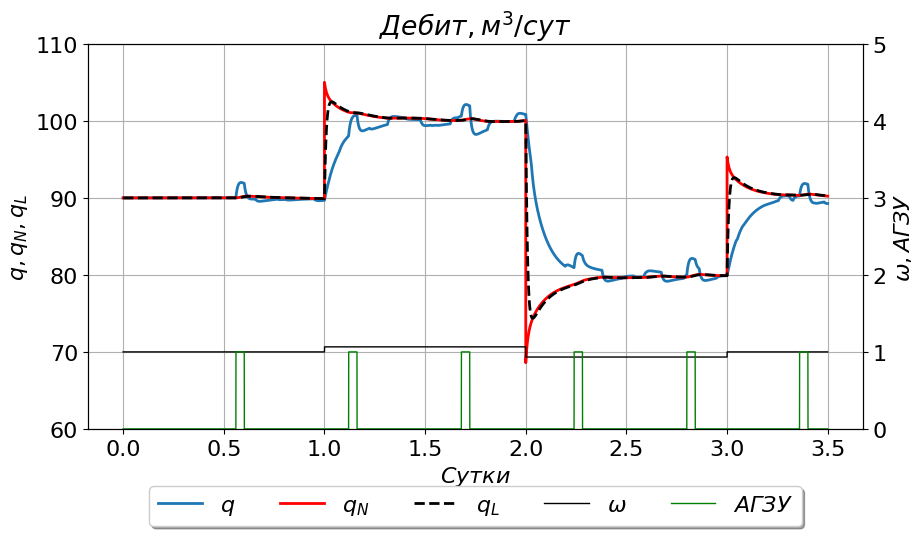

In [256]:
plot_data = [
             (PlotData(df['q'], '', 2, 'q'),
              PlotData(df['q_N'], 'r', 2, 'q_N'),
              PlotData(df['q_L'], 'k--', 2, 'q_L')
              ),

             (PlotData(df['u'], 'k', 1, '\omega'),
              PlotData(df['agzu'], 'g', 1, 'АГЗУ')
              ),
            ]

build_plot(x, plot_data, '$Дебит, м^3/сут$', y_scale = [Scale(min=60, max=110), Scale(min=0, max=5)])

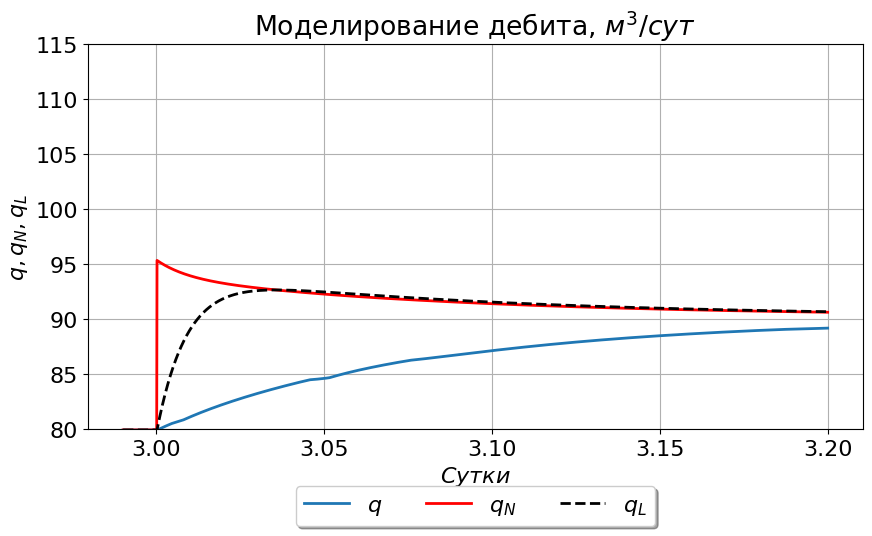

In [257]:
plot_data = [
             (PlotData(df['q'], '', 2, 'q'),
              PlotData(df['q_N'], 'r', 2, 'q_N'),
              PlotData(df['q_L'], 'k--', 2, 'q_L')),
            ]

build_plot(x, plot_data, 'Моделирование дебита, $м^3/сут$', y_scale = [Scale(min=80, max=115)], x_scale=Scale(min=2.99, max=3.2))

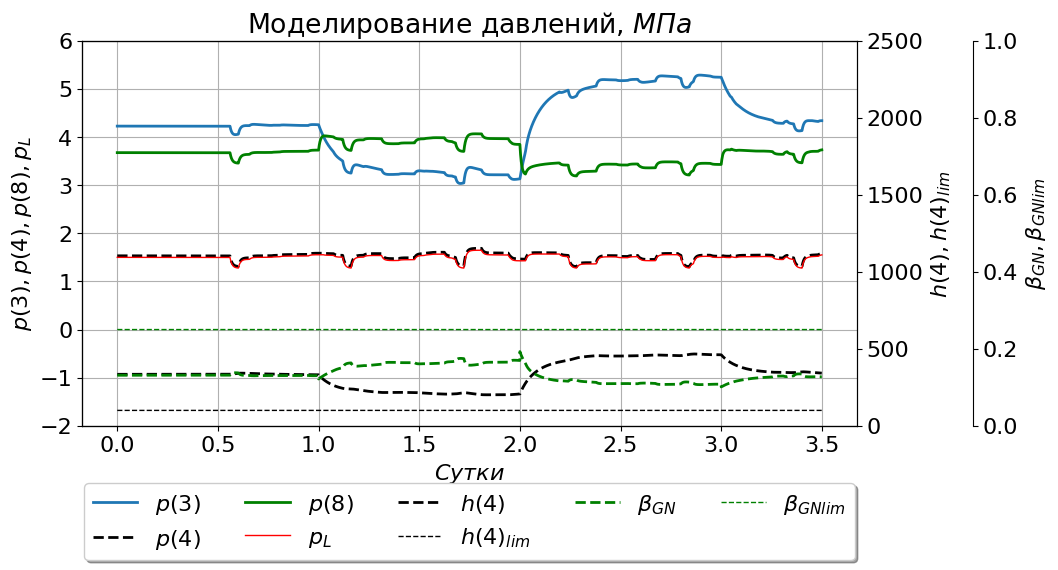

In [258]:
plot_data = [
             (PlotData(df['p_3'], '', 2, 'p(3)'),
              PlotData(df['p_4'], 'k--', 2, 'p(4)'),
              PlotData(df['p_8'], 'g', 2, 'p(8)'),
              PlotData(df['p_L'], 'r', 1, 'p_L')
              ),

             (PlotData(df['h_4'], 'k--', 2, 'h(4)'),
              PlotData(pd.Series([h_lim]*k), 'k--', 1, 'h(4)_{lim}')
              ),

             (PlotData(df['betta_GN'], 'g--', 2, '\\beta_{GN}'),
              PlotData(pd.Series([betta_G_lim]*k), 'g--', 1, '\\beta_{GNlim}')
              ),
            ]

build_plot(x, plot_data, 'Моделирование давлений, $МПа$', y_scale = [Scale(min=-2, max=6), Scale(min=0, max=2500), Scale(min=0, max=1)])

In [259]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from datetime import datetime, timedelta


class Meter:

  def __init__(self):
    self.noise_enable = False

  def measure(self, df, quant_step=0.1, denominator=7):
    """Сделать выборку измерений"""

    ident_k = (k//denominator)
    ident_dt = dt * denominator
    x_time = x[::denominator]

    quant = np.linspace(0, 100, int(100/quant_step))


    df_ident = pd.DataFrame({'p_3': [quant[round(index/quant_step)] for index in self.add_noise(df['p_3'])[::denominator]],
                             'p_4': [quant[round(index/quant_step)] for index in self.add_noise(df['p_4'])[::denominator]],
                             'p_8': [quant[round(index/quant_step)] for index in self.add_noise(df['p_8'])[::denominator]],
                             'p_L': [quant[round(index/quant_step)] for index in self.add_noise(df['p_L'])[::denominator]],
                             })

    return x_time, df_ident

  def add_noise(self, data):
    if self.noise_enable:
      return add_noise(data)[0]

    return data


def get_with_error(val, hf_amplitude):
  return val *random.uniform(-hf_amplitude/2, hf_amplitude/2)

def generate_hf_noise(arr, hf_amplitude):
  return [get_with_error(val, hf_amplitude=hf_amplitude) if i%10==0 else 0 for i, val in enumerate(arr)]


def add_noise(clean_data,
              dt=dt,
              lf_amplitude=0.03,
              hf_amplitude=0.01,
              lf_cutoff=0.5):
    """
    Добавляет низкочастотный и высокочастотный шум к данным давления с привязкой к суточному времени

    Параметры:
    clean_data - массив чистых данных давления
    sample_interval_min - интервал между измерениями в минутах
    lf_amplitude - амплитуда низкочастотного шума (доля от диапазона данных)
    hf_amplitude - амплитуда высокочастотного шума (доля от диапазона данных)
    lf_cutoff - частота среза для НЧ шума
    random_seed - зерно для генератора случайных чисел

    Возвращает:
    noisy_data - зашумленные данные
    lf_noise - низкочастотный шум
    hf_noise - высокочастотный шум
    """

    n = len(clean_data)
    data_range = np.max(clean_data) - np.min(clean_data)

    fs = 1.0 / dt  # частота дискретизации

    # 1. Генерация низкочастотного шума (дрейф)
    # Для суточных данных НЧ шум должен быть очень низкочастотным
    b, a = signal.butter(2, lf_cutoff / (fs/2), 'low')
    lf_noise = signal.lfilter(b, a, np.random.randn(n))
    lf_noise = lf_amplitude * data_range * (lf_noise / np.max(np.abs(lf_noise)))

    # 2. Генерация высокочастотного шума
    hf_noise = generate_hf_noise(clean_data, hf_amplitude)

    # 3. Комбинация шумов с чистыми данными
    noisy_data = clean_data + lf_noise + hf_noise

    return noisy_data, lf_noise, hf_noise

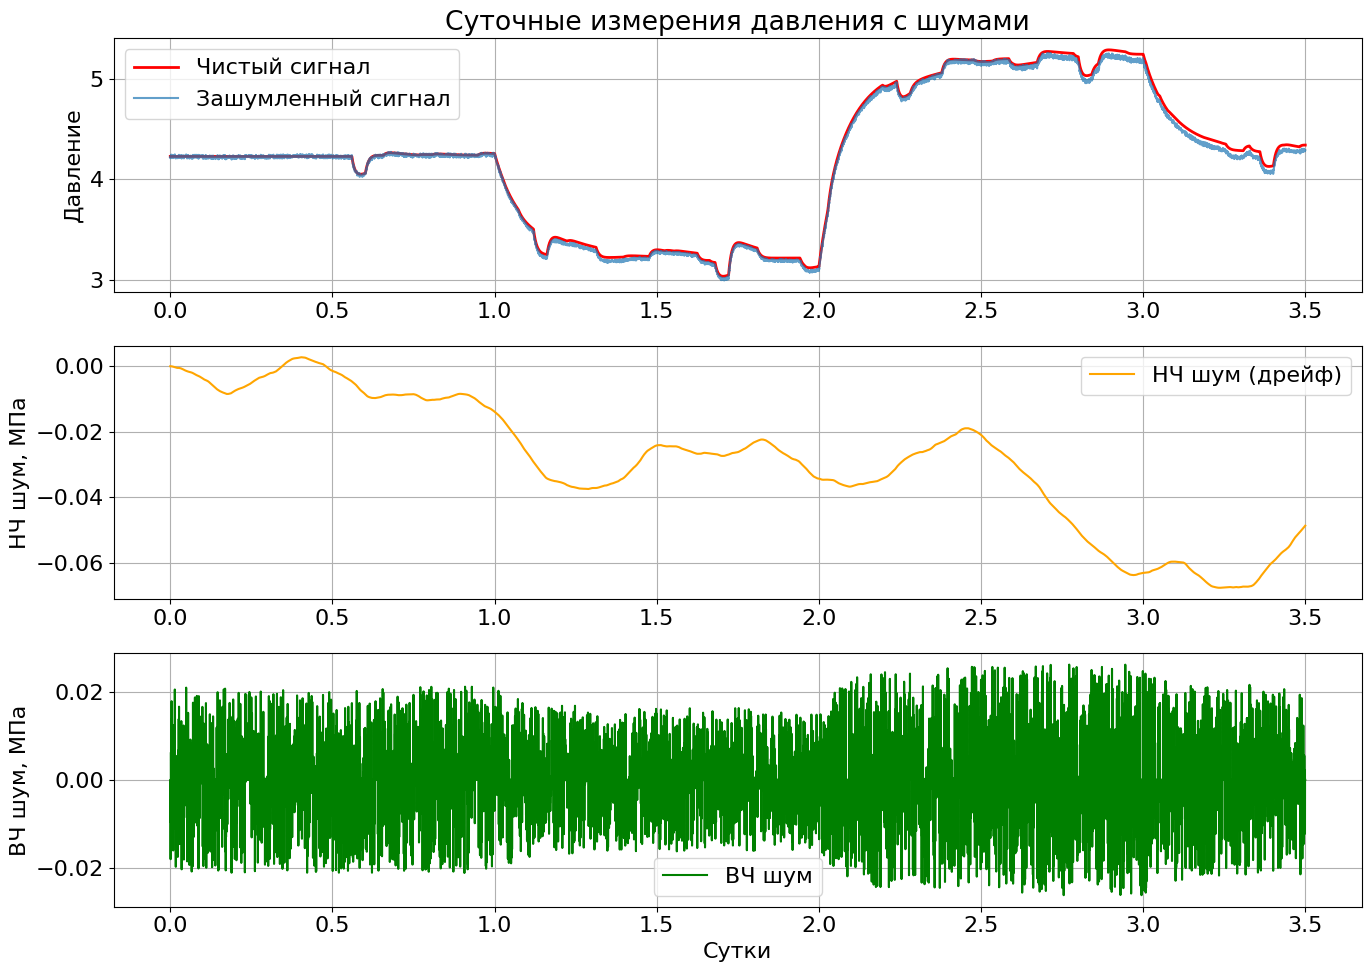

In [260]:
    # Добавление шумов
    clean_pressure = df['p_3']

    # Добавление шумов
    noisy_pressure, lf_noise, hf_noise = add_noise(clean_pressure)

    # Визуализация
    plt.figure(figsize=(14, 10))

    # График давления
    plt.subplot(3, 1, 1)
    plt.plot(x, clean_pressure, label='Чистый сигнал', color='r', lw=2)
    plt.plot(x, noisy_pressure, label='Зашумленный сигнал', alpha=0.7)
    plt.ylabel('Давление')
    plt.title('Суточные измерения давления с шумами')
    plt.legend()
    plt.grid()

    # График НЧ шума
    plt.subplot(3, 1, 2)
    plt.plot(x, lf_noise, label='НЧ шум (дрейф)', color='orange')
    plt.ylabel('НЧ шум, МПа')
    plt.legend()
    plt.grid()

    # График ВЧ шума
    plt.subplot(3, 1, 3)
    plt.plot(x, hf_noise, label='ВЧ шум', color='green')
    plt.ylabel('ВЧ шум, МПа')
    plt.xlabel('Сутки')
    plt.legend()
    plt.grid()


    plt.tight_layout()
    plt.show()

In [261]:

meter = Meter()

x_time, df_ident = meter.measure(df)


,p_3,p_4,p_8,p_L
0,4.204204,1.501502,3.703704,1.501502
1,4.204204,1.501502,3.703704,1.501502
2,4.204204,1.501502,3.703704,1.501502
3,4.204204,1.501502,3.703704,1.501502
4,4.204204,1.501502,3.703704,1.501502
...,...,...,...,...
4995,4.304304,1.601602,3.703704,1.501502
4996,4.304304,1.601602,3.703704,1.501502
4997,4.304304,1.601602,3.703704,1.501502
4998,4.304304,1.601602,3.703704,1.601602


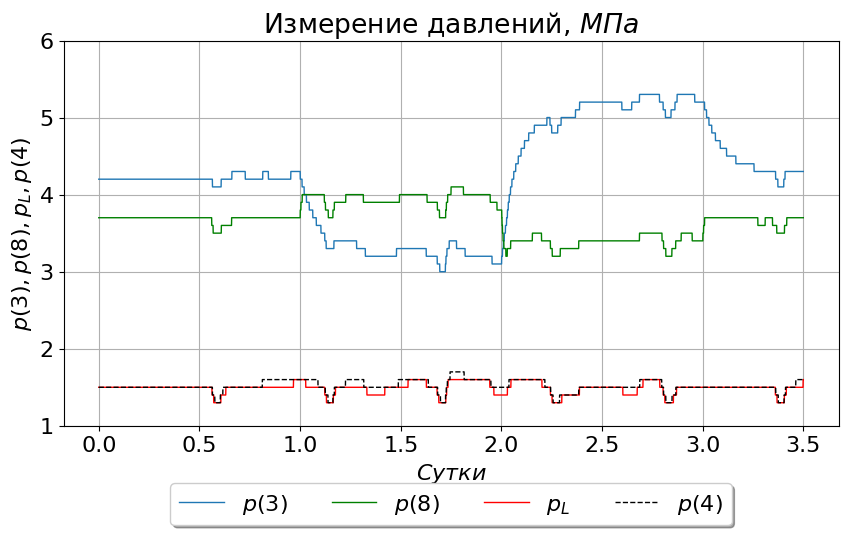

In [274]:

plot_data = [
             (PlotData(df_ident['p_3'], '', 1, 'p(3)'),
              PlotData(df_ident['p_8'], 'g', 1, 'p(8)'),
              PlotData(df_ident['p_L'], 'r', 1, 'p_L'),
              PlotData(df_ident['p_4'], 'k--', 1, 'p(4)'),
              ),

            ]

build_plot(x_time, plot_data, 'Измерение давлений, $МПа$', y_scale = [Scale(min=1, max=6)])

In [264]:
# Идентификация через производные

#from dataclasses import dataclass, field
#from typing import List
#@dataclass
#class CalculatedValues:
#  values: List[float] = field(default_factory=list)
#  def add(self, element):
#    self.values.append(element)
#calc_q = CalculatedValues()
#calc__q = CalculatedValues()
#calc_q_N = CalculatedValues()
#calc_dp = CalculatedValues()
#calc_dp_3 = CalculatedValues()
#calc_dp_4 = CalculatedValues()
#calc_y = CalculatedValues()
#for _k in range(ident_k-1):
#  q_N = (1/(gamma*r_U))*(df_ident['p_8'][_k+1]-p_L)
#  dp_3 = (1/ident_dt)*(df_ident['p_3'][_k+1]-df_ident['p_3'][_k])
#  dp_4 = (1/ident_dt)*(df_ident['p_4'][_k+1]-df_ident['p_4'][_k])
#  dp = dp_3 - dp_4
#  q = q_N + ((S_t/gamma) * dp)
#  if _k == 0:
#    _q = q
#  else:
#    _q = _q + (ident_dt/T_2)*(q - _q)
#  y = df_ident['p_3'][_k] + gamma*(H_R-H_N+r_K*q)
#  calc_q_N.add(q_N)
#  calc_q.add(q)
#  calc__q.add(_q)
#  calc_dp.add(dp)
#  calc_dp_3.add(dp_3)
#  calc_dp_4.add(dp_4)
#  calc_y.add(y)
#
# calc_df = pd.DataFrame({'q_N': calc_q_N.values, 'q': calc_q.values, '_q': calc__q.values, 'dp': calc_dp.values, 'dp_3': calc_dp_3.values, 'dp_4': calc_dp_4.values, 'y': calc_y.values})
#
#
# # формируем и заполняем матрицу размерностью 2x2
#A = np.empty((3, 3))
#A[[0], [0]] = ident_k-1
#A[[0], [1]] = sum(calc_q.values)
#A[[0], [2]] = sum(calc__q.values)
#
#A[[1], [0]] = sum(calc_q.values)
#A[[1], [1]] = sum([value**2 for value in calc_q.values])
#A[[1], [2]] = sum([calc__q.values[i]*calc_q.values[i] for i in range(ident_k-1)])
#
#A[[2], [0]] = sum(calc__q.values)
#A[[2], [1]] = sum([calc__q.values[i]*calc_q.values[i] for i in range(ident_k-1)])
#A[[2], [2]] = sum([value**2 for value in calc__q.values])
#A
#
#
## находим обратную матрицу
#A = np.linalg.inv(A)
## формируем и заполняем матрицу размерностью 3x1
#C = np.empty((3, 1))
#C[0] = sum(calc_y.values)
#C[1] = sum([calc_y.values[i]*calc_q.values[i] for i in range(ident_k-1)])
#C[2] = sum([calc_y.values[i]*calc__q.values[i] for i in range(ident_k-1)])
#C
#
## умножаем матрицу на вектор
#ww = np.dot(A, C)
#ww
#
#
#import scipy
#X = np.array([[1 for _ in range(ident_k-1)],
#              calc_q.values,
#              calc__q.values]).T
#y = np.array([calc_y.values]).T
#b, squared_error_sum, matrix_rank, SVD_ = scipy.linalg.lstsq(X, y)
#print(b)
#
#
#
#from matplotlib import pyplot as plt
#fig, ax = plt.subplots(figsize=(10, 5))
#twin1 = ax.twinx()
#
#plt.rcParams.update({'font.size': 16})
#
#p1, = ax.plot(df['x'], df['q'], 'b', lw=2, label="q")
#p2, = ax.plot(df['x'], df['q_N'], 'r', lw=2, label="$q_N$")
#p3, = ax.plot(df['x'], df['q_L'], 'k--', lw=2, label="$q_L$")
#
#p4, = twin1.plot(df['x'],  df['u']*40,'k', lw=1, label="w")
#
#
#ax.set(ylim=(40, 125), xlabel="Сутки", ylabel="q, $q_N$, $q_L$")
#twin1.set(ylim=(0, 160), ylabel="$\omega$")
#
#plt.title('Моделирование дебита, $м^3/сут$')
#
#ax.legend(handles=[p1, p2, p3, p4])
#ax.grid()
#plt.show()
#
#
#
#
#from matplotlib import pyplot as plt
#fig, ax = plt.subplots(figsize=(10, 5))
#
#twin1 = ax.twinx()
#
#p1, = ax.plot(df['x'], df['p_8'], 'r', lw=2, label="$p(8)$")
#p2, = ax.plot(df['x'], df['p_3'], 'b', lw=2, label="$p(3)$")
#
#p3, = twin1.plot(df['x'], df['p_1'], 'k--', lw=2, label="$p(1)$")
#
#
#ax.set(ylim=(0, 16), xlabel="Сутки", ylabel="$p(3)$, $p(8)$")
#twin1.set(ylim=(0, 22), ylabel="$p(1)$")
#plt.title('Моделирование давлений, $МПа$')
#ax.legend(handles=[p1, p2, p3])
#ax.grid()
#plt.show()
#
#
#
#
#from matplotlib import pyplot as plt
#fig, ax = plt.subplots(figsize=(10, 5))
#
#twin1 = ax.twinx()
#
#p1, = ax.step(df['x'][:-denominator:denominator], calc_df['q'], 'b', lw=1, label="$q$")
##p2, = ax.plot([index*denominator for index in df['x'][:ident_k-1]], calc_df['q_N'][:ident_k], 'r', lw=2, label="$q_N$")
#p3, = ax.step(df['x'][:-denominator:denominator], calc_df['_q'], 'k--', lw=1, label="$\hat{q}$")
#
#
#p4, = twin1.plot(df['x'], df['q'], 'r--', lw=2, label="$q модель$")
##p5, = twin1.plot(df['x'], df['q_N'], 'r--', lw=1, label="$q_N модель$")
#
#
#ax.set(ylim=(40, 140), xlabel="Сутки", ylabel="$q$, $q_N$, $\hat{q}$")
#twin1.set(ylim=(40, 140), ylabel="$q$, $q_N$, $\hat{q}$")
#
#ax.legend(handles=[p1, p3, p4])
#ax.grid()
#plt.show()
#
#
#from matplotlib import pyplot as plt
#fig, ax = plt.subplots(figsize=(10, 5))
#
#twin1 = ax.twinx()
#
##p1, = ax.plot([index*denominator for index in df['x'][:ident_k-1]], calc_df['q'][:ident_k], 'b', lw=3, label="$q$")
#p2, = ax.step(df['x'][:-denominator:denominator], calc_df['q_N'], 'b', lw=2, label="$q_N$")
##p3, = ax.plot([index*denominator for index in df['x'][:ident_k-1]], calc_df['_q'][:ident_k], 'k--', lw=1, label="$\hat{q}$")
#
#
##p4, = twin1.plot(df['x'], df['q'], 'r--', lw=2, label="$q модель$")
#p5, = twin1.plot(df['x'], df['q_N'], 'r--', lw=2, label="$q_N модель$")
#
#
#ax.set(ylim=(0, 140), xlabel="Сутки", ylabel="$q$, $q_N$, $\hat{q}$")
#twin1.set(ylim=(0, 140), ylabel="$q$, $q_N$, $\hat{q}$")

#ax.legend(handles=[p2, p5])
#ax.grid()
#plt.show()

In [ ]:
# Идентификация через фильтр

from dataclasses import dataclass, field

@dataclass
class CalculatedValues:
  values: list[float] = field(default_factory=list)

  def add(self, element):
    self.values.append(element)


calc_q_L = CalculatedValues()
calc_dp = CalculatedValues()
calc_dp_t = CalculatedValues()
calc_q_t = CalculatedValues()
calc_p_1_t = CalculatedValues()
calc__q_t = CalculatedValues()

for _k in range(ident_k):

  q_L = (1/(gamma*r_U))*(df_ident['p_8'][_k]-df_ident['p_L'][_k])
  dp = (df_ident['p_3'][_k]-df_ident['p_4'][_k])

  if _k == 0:
    dp_t = dp


  q_t = q_L + ((S_t/(gamma*t_N)) * (dp - dp_t))

  if _k == 0:
    _q_t = q_t
    _p_3 = df_ident['p_3'][0]

  p_1_t = _p_3 + gamma*(H_R-H_N+r_K*q_t)

  calc_q_L.add(q_L)
  calc_dp.add(dp)
  calc_dp_t.add(dp_t)
  calc_q_t.add(q_t)
  calc_p_1_t.add(p_1_t)
  calc__q_t.add(_q_t)

  dp_t = dp_t + (ident_dt/t_N)*(dp - dp_t)
  _q_t = _q_t + (ident_dt/T_2)*(q_t - _q_t)
  _p_3 = _p_3 + (ident_dt/t_N)*(df_ident['p_3'][_k] - _p_3)


calc_df = pd.DataFrame({'q_L': calc_q_L.values,
                        'dp': calc_dp.values,
                        'dp_t': calc_dp_t.values,
                        'q_t': calc_q_t.values,
                        'p_1_t': calc_p_1_t.values,
                        '_q_t': calc__q_t.values,
                        })


In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p2, = twin1.step(df['x'], df['p_1'], 'r', lw=2, label="$p(1)$ модель")
p1, = ax.step(x_time, calc_df['p_1_t'], 'b', lw=1, label=r"$p(1)_\tau$ расчёт")


ax.set(ylim=(10, 15), xlabel="Сутки", ylabel="$p(1)$")
twin1.set(ylim=(10, 15), ylabel="$p(1)$")

plt.title('Восстановление давления на забое, $МПа$')

ax.legend(handles=[p1, p2])
ax.grid()
plt.show()

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.step(x_time, calc_df['q_t'], 'b', lw=1, label=r"$q_\tau$ расчёт")
p2, = ax.step(x_time, calc_df['_q_t'], 'k--', lw=2, label=r"$\^{q}_\tau$ расчёт")
p3, = twin1.plot(df['x'], df['q'], 'r', lw=2, label="$q$ модель")


ax.set(ylim=(0, 160), xlabel="Сутки", ylabel="$q$")
twin1.set(ylim=(0, 160), ylabel=r"$q_\tau$, $\^{q}_\tau$")

plt.title('Восстановление дебитов через фильтр, $м^3/сут$')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, handles=[p1, p2, p3])
ax.grid()
plt.show()

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.plot(x_time, calc_df['q_L'], 'b', lw=1, label=r"$q_L$ расчёт")
p2, = ax.plot(df['x'], df['q_L'], 'r', lw=3, label="$q_L$ модель")

ax.set(ylim=(0, 140), xlabel="Сутки", ylabel="$q_L$")
twin1.set(ylim=(0, 140), ylabel=r"$q_L$")

plt.title('Восстановление дебита насоса, $м^3/сут$')

ax.legend(handles=[p1, p2])
ax.grid()
plt.show()

In [ ]:
import scipy
X = np.array([[1 for _ in range(ident_k)],
              calc_q_t.values,
              calc__q_t.values]).T
y = np.array([calc_p_1_t.values]).T
b, squared_error_sum, matrix_rank, SVD_ = scipy.linalg.lstsq(X, y)
print(b)

In [ ]:
p_error = (p_R - b[0][0])/p_R
p_error *= 100
p_error

In [ ]:
r_1_error = (r_1 - -b[1][0])/r_1
r_1_error *= 100
r_1_error

In [ ]:
r_2_error = (r_2 - -b[2][0])/r_2
r_2_error *= 100
r_2_error

In [ ]:
k_s = 0
s_indexes = []
s_time = []
d_qt = []

_q_t = calc_df['_q_t']

for i in range(4800//denominator):
  time = i*ident_dt

  q = df['q'][i*denominator]

  k_s += 1
  d_qt.append(_q_t[i])
  s_indexes.append(i)
  s_time.append(i*ident_dt)

s_q_t = [calc__q_t.values[i] for i in s_indexes]
s_p_t = [calc_p_1_t.values[i] for i in s_indexes]

m2 = ident_k / k_s


In [ ]:
# формируем и заполняем матрицу размерностью 2x2
A1 = np.empty((3, 3))
A1[[0], [0]] = ident_k
A1[[0], [1]] = -sum(calc_q_t.values)
A1[[0], [2]] = -sum(calc__q_t.values)

A1[[1], [0]] = -sum(calc_q_t.values)
A1[[1], [1]] = sum([value**2 for value in calc_q_t.values])
A1[[1], [2]] = sum([calc__q_t.values[i]*calc_q_t.values[i] for i in range(ident_k)])

A1[[2], [0]] = -sum(calc__q_t.values)
A1[[2], [1]] = sum([calc__q_t.values[i]*calc_q_t.values[i] for i in range(ident_k)])
A1[[2], [2]] = sum([value**2 for value in calc__q_t.values])

A2 = np.empty((3, 3))
A2[[0], [0]] = k_s
A2[[0], [1]] = -sum(s_q_t)
A2[[0], [2]] = -sum(s_q_t)

A2[[1], [0]] = -sum(s_q_t)
A2[[1], [1]] = sum([value**2 for value in s_q_t])
A2[[1], [2]] = sum([value**2 for value in s_q_t])

A2[[2], [0]] = -sum(s_q_t)
A2[[2], [1]] = sum([value**2 for value in s_q_t])
A2[[2], [2]] = sum([value**2 for value in s_q_t])

A2 = m2 * A2

v_r = r_1/r_2

A3 = np.empty((3, 3))
A3[[0], [0]] = 0
A3[[0], [1]] = 0
A3[[0], [2]] = 0

A3[[1], [0]] = 0
A3[[1], [1]] = 1
A3[[1], [2]] = -v_r

A3[[2], [0]] = 0
A3[[2], [1]] = -v_r
A3[[2], [2]] = v_r * v_r

A3 = ident_k * A3

A = A1 + A2 + A3

# находим обратную матрицу
A = np.linalg.inv(A)
# формируем и заполняем матрицу размерностью 3x1
C1 = np.empty((3, 1))
C1[0] = sum(calc_p_1_t.values)
C1[1] = -sum([calc_p_1_t.values[i]*calc_q_t.values[i] for i in range(ident_k)])
C1[2] = -sum([calc_p_1_t.values[i]*calc__q_t.values[i] for i in range(ident_k)])

C2 = np.empty((3, 1))
C2[0] = sum(s_p_t)
C2[1] = -sum([s_p_t[i]*s_q_t[i] for i in range(k_s)])
C2[2] = -sum([s_p_t[i]*s_q_t[i] for i in range(k_s)])

C2 = m2 * C2

C = C1 + C2

# умножаем матрицу на вектор
ww = np.dot(A, C)
ww

In [ ]:
p_error = (p_R - ww[0][0])/p_R
p_error *= 100
p_error

In [ ]:
p_error = (r_1 - ww[1][0])/r_1
p_error *= 100
p_error

In [ ]:
p_error = (r_2 - ww[2][0])/r_2
p_error *= 100
p_error

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.step(x_time, calc_df['_q_t'], 'k--', lw=2, label=r"$\^{q}_\tau$ расчёт")
p2 = ax.scatter(s_time, d_qt, label=r"Статика")
p3, = twin1.plot(df['x'], df['q'], 'r', lw=2, label="$q$ модель")


ax.set(ylim=(40, 120), xlabel="Сутки", ylabel="$q$")
twin1.set(ylim=(40, 120), ylabel=r"$q_\tau$, $\^{q}_\tau$")

plt.title('Восстановление дебитов через фильтр, $м^3/сут$')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, handles=[p1, p2, p3])
ax.grid()
plt.show()